# Canola weekly

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import glob
import xarray as xr
import os

import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 

from sklearn.linear_model import LinearRegression

from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils.plotting import plot_series

import seaborn as sns

In [2]:
#read dataframe 
canola_2 = df = pd.read_csv('../data/rm-yields-data.csv', header=0, index_col=0, parse_dates=True)
canola_small = canola_2.iloc[:, [0, 2]].copy()

#cut 70s and 80s as well 
#cut of first 52 observations (NAs)
canola_small.drop(canola_small.index[:52], inplace=True)

#filter out every observation that contains NAs
canola_filtered = canola_small.groupby('RM').filter(lambda group: not group['Canola'].isnull().any())

# how may districts? 148
num_districts = canola_filtered.groupby('RM').ngroups
print(num_districts)
#excluding 70s and 80s lead to 36 more colmplete districts 


#extract only the first district 
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

184


In [3]:
# Group by 'RM' and check if 'Canola' has any missing values in each group
districts_with_full_data = canola_filtered.groupby('RM')['Canola'].apply(lambda group: not group.isnull().any())

# Extract the list of districts with full data
districts_with_full_data_list = districts_with_full_data[districts_with_full_data].index.tolist()

# Print or use the list as needed
print("Districts with full data:", districts_with_full_data_list)
print(len(districts_with_full_data_list))

Districts with full data: [1, 2, 3, 31, 32, 33, 34, 61, 63, 64, 65, 66, 91, 92, 93, 95, 96, 121, 122, 123, 124, 125, 126, 127, 131, 151, 152, 153, 154, 155, 156, 157, 158, 181, 183, 184, 185, 186, 189, 190, 194, 211, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 241, 243, 244, 245, 246, 247, 248, 250, 251, 252, 253, 254, 255, 256, 271, 273, 276, 277, 278, 280, 281, 282, 283, 284, 288, 304, 305, 307, 308, 309, 310, 312, 313, 314, 315, 316, 317, 320, 331, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 349, 350, 351, 352, 366, 367, 368, 369, 370, 371, 372, 373, 376, 377, 378, 379, 380, 381, 382, 394, 395, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 408, 409, 410, 411, 426, 427, 428, 429, 430, 431, 435, 436, 437, 438, 439, 440, 442, 456, 457, 458, 459, 460, 461, 463, 464, 466, 467, 468, 471, 472, 486, 487, 488, 490, 491, 493, 494, 497, 499, 501, 502, 520, 529, 588, 622]
184


In [4]:
#open only the years from 1990 til 2022

# Define the directory path and pattern for the NetCDF files
directory_path = '../data/raw_data/'
file_pattern = 'data_*.nc'

# Get a list of files matching the pattern
files_to_open = glob.glob(os.path.join(directory_path, file_pattern))

# Open only the files for the years 1990 to 2022
years_to_open = list(map(str, range(1990, 2023)))
files_to_open = [file for file in files_to_open if any(year in file for year in years_to_open)]

# Use open_mfdataset to open the selected files
cop_all = xr.open_mfdataset(files_to_open, combine='by_coords')

cop_all_centralized = cop_all.mean(dim=['latitude', 'longitude'])

print(cop_all_centralized)

<xarray.Dataset>
Dimensions:  (time: 169488)
Coordinates:
  * time     (time) datetime64[ns] 1990-04-01 ... 2022-10-31T23:00:00
Data variables:
    t2m      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    tp       (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>


<YearEnd: month=12>
ADF Statistic: -5.2203605543583045
p-value: 7.988437769094104e-06


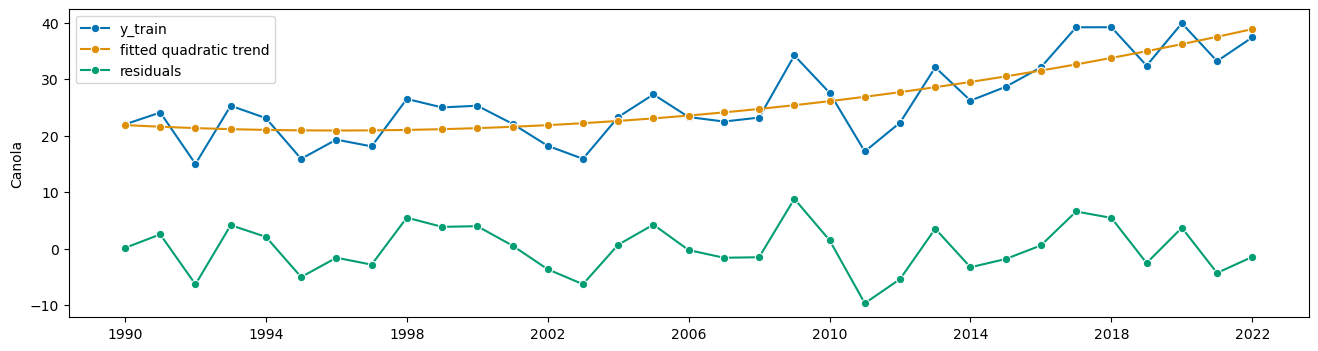

In [5]:
canola_dist1.index = canola_dist1.index.to_period('A')

#change frequency 
frequency = canola_dist1.index.freq

print(frequency)

# linear detrending
forecaster = PolynomialTrendForecaster(degree=2)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(canola_dist1['Canola'])


forecaster = PolynomialTrendForecaster(degree=2)
fh_ins = -np.arange(len(canola_dist1['Canola'])) 
y_pred = forecaster.fit(canola_dist1['Canola']).predict(fh=fh_ins)

plot_series(canola_dist1['Canola'], y_pred, yt, labels=["y_train", "fitted quadratic trend", "residuals"]);

residuals = yt

#ADF 
result = adfuller(residuals)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

In [6]:
column_to_append = yt.tolist()

dist1_df = cop_all_centralized.to_dataframe()

years = dist1_df.index.year
dist1_df['Canola_detrend'] = [column_to_append[year - 1990] for year in years]

dist1_df.head()

,t2m,tp,Canola_detrend
time,,,
1990-04-01 00:00:00,277.637482,0.001674,0.126669
1990-04-01 01:00:00,275.720703,0.001619,0.126669
1990-04-01 02:00:00,274.728241,0.002952,0.126669
1990-04-01 03:00:00,274.531769,0.003524,0.126669
1990-04-01 04:00:00,274.243988,0.003615,0.126669


In [7]:
column_to_append = yt.tolist()

canola_dist1.loc[:, 'Canola_detrend'] = column_to_append

canola_dist1.drop(canola_dist1.columns[:2], axis=1, inplace=True)

#canola_dist1

C:\Users\maris\AppData\Local\Temp\ipykernel_42520\3757530005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:, 'Canola_detrend'] = column_to_append
C:\Users\maris\AppData\Local\Temp\ipykernel_42520\3757530005.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.drop(canola_dist1.columns[:2], axis=1, inplace=True)


### Extract Features 

In [12]:
#Use features: average of max temp in one week and the total precipitation in one week 

# Resample by week and calculate the mean temperature for each week
daily_max_temperatures = dist1_df.resample('D').max()
daily_max_temperatures = daily_max_temperatures.dropna()

# Resample again to get the average of the maximum temperatures for each week
weekly_avg_max_temperatures = daily_max_temperatures.resample('W-Mon').mean()
weekly_avg_max_temperatures = weekly_avg_max_temperatures.dropna()

# Resample to get the cumulative percipitation for each week
weekly_cum_rain = dist1_df.resample('W-Mon').sum()
weekly_cum_rain = weekly_cum_rain.dropna()

# Initialize the new column with zeros
weekly_avg_max_temperatures['week_number'] = 0
weekly_cum_rain['week_number'] = 0 

# Create a new column with the number of the week

for timestamp in weekly_avg_max_temperatures.index:
    
    iso_year, iso_week, _ = timestamp.isocalendar()
    weekly_avg_max_temperatures.at[timestamp, 'week_number'] = iso_week
    
for timestamp in weekly_cum_rain.index:
    
    iso_year, iso_week, _ = timestamp.isocalendar()
    weekly_cum_rain.at[timestamp, 'week_number'] = iso_week

    
# Find range of weeks 
min_value = weekly_avg_max_temperatures['week_number'].min()
max_value = weekly_avg_max_temperatures['week_number'].max()

# Start from week 15 since week 14 is not complete for all years, same for week 45
for week in range(15, 45):
    
    week_data_temp = weekly_avg_max_temperatures[weekly_avg_max_temperatures['week_number'] == week]
    column_to_append = week_data_temp['t2m'].tolist()
    canola_dist1.loc[:, f'avg_max_temp_in_week_{week}'] = column_to_append
    
    week_data_rain = weekly_cum_rain[weekly_cum_rain['week_number'] == week]
    column_to_append = week_data_rain['tp'].tolist()
    canola_dist1.loc[:, f'total_rain_week_{week}'] = column_to_append
    

print(canola_dist1.columns)
#canola_dist1.head()

#ergiebt laggen überhaupt Sinn?

Index(['Canola_detrend', 'avg_max_temp_in_week_15', 'total_rain_week_15',
       'avg_max_temp_in_week_16', 'total_rain_week_16',
       'avg_max_temp_in_week_17', 'total_rain_week_17',
       'avg_max_temp_in_week_18', 'total_rain_week_18',
       'avg_max_temp_in_week_19', 'total_rain_week_19',
       'avg_max_temp_in_week_20', 'total_rain_week_20',
       'avg_max_temp_in_week_21', 'total_rain_week_21',
       'avg_max_temp_in_week_22', 'total_rain_week_22',
       'avg_max_temp_in_week_23', 'total_rain_week_23',
       'avg_max_temp_in_week_24', 'total_rain_week_24',
       'avg_max_temp_in_week_25', 'total_rain_week_25',
       'avg_max_temp_in_week_26', 'total_rain_week_26',
       'avg_max_temp_in_week_27', 'total_rain_week_27',
       'avg_max_temp_in_week_28', 'total_rain_week_28',
       'avg_max_temp_in_week_29', 'total_rain_week_29',
       'avg_max_temp_in_week_30', 'total_rain_week_30',
       'avg_max_temp_in_week_31', 'total_rain_week_31',
       'avg_max_temp_in_week_3